
# ***lien Github*** : https://github.com/GhazwaMa/DM_Project

>  ***Ghazwa Machfar*** 3DNI1
>
>  **Projet Data Mining**


## collecte des tweets

In [18]:
from tweepy import OAuthHandler
from tweepy import API

# Consumer key authentication
auth = OAuthHandler("vdA0dkB3GxvhXHgeXMONmWYoH", "uvdUl6VZNhT1huqeYlE2HYmN57VaM6Rco4HpGbhwZ5Y2B7Ubyy")

# Access key authentication
auth.set_access_token("1331310694105559046-ShzOiLPVT7pT5vnQsGphlwPMSrEOSU", "CTFsbUPR6mv8adDrImixmnfDOT0M6I9YgQgoo9AprIgTJ")

# Set up the API with the authentication handler
api = API(auth)


In [19]:
from tweepy.streaming import StreamListener
import json
import time
import sys

class SListener(StreamListener):
    def __init__(self, api = None, fprefix = 'streamer'):
        self.api = api or API()
        self.counter = 0
        self.fprefix = fprefix
        self.output  = open('%s_%s.json' % (self.fprefix, time.strftime('%Y%m%d-%H%M%S')), 'w')


    def on_data(self, data):
        if  'in_reply_to_status' in data:
            self.on_status(data)
        elif 'delete' in data:
            delete = json.loads(data)['delete']['status']
            if self.on_delete(delete['id'], delete['user_id']) is False:
                return False
        elif 'limit' in data:
            if self.on_limit(json.loads(data)['limit']['track']) is False:
                return False
        elif 'warning' in data:
            warning = json.loads(data)['warnings']
            print("WARNING: %s" % warning['message'])
            return


    def on_status(self, status):
        self.output.write(status)
        self.counter += 1
        if self.counter >= 20000:
            self.output.close()
            self.output  = open('%s_%s.json' % (self.fprefix, time.strftime('%Y%m%d-%H%M%S')), 'w')
            self.counter = 0
        return


    def on_delete(self, status_id, user_id):
        print("Delete notice")
        return


    def on_limit(self, track):
        print("WARNING: Limitation notice received, tweets missed: %d" % track)
        return


    def on_error(self, status_code):
        print('Encountered error with status code:', status_code)
        return 


    def on_timeout(self):
        print("Timeout, sleeping for 60 seconds...")
        time.sleep(60)
        return 


In [13]:
from tweepy import Stream

# Set up words to track
keywords_to_track = ["hello","you"]

# Instantiate the SListener object 
listen = SListener(api)

# Instantiate the Stream object
stream = Stream(auth, listen)

# Begin collecting data
stream.filter(track = keywords_to_track)

KeyboardInterrupt: 

In [21]:
import glob
tweets = []
files  = list(glob.iglob('streamer_*.json'))
for f in files:
    fh = open(f, 'r', encoding = 'utf-8')
    tweets_json = fh.read().split("\n")

    ## remove empty lines
    tweets_json = list(filter(len, tweets_json))

    ## parse each tweet
    for tweet in tweets_json:
        try:
            tweet_obj = json.loads(tweet)

            ## flatten the file to include quoted status and retweeted status info
            if 'quoted_status' in tweet_obj:
                tweet_obj['quoted_status-text'] = tweet_obj['quoted_status']['text'] 
                tweet_obj['quoted_status-user-screen_name'] = tweet_obj['quoted_status']['user']['screen_name']

            if 'retweeted_status' in tweet_obj:
                tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']
                tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']

            tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']

            tweets.append(tweet_obj)
        except:
            pass

print(len(tweets))

62281


# Prétraitement des tweets
Le nettoyage des tweets comprendra plusieurs choses :

> - Enlever les emojis : pour cela il faut un module Python spécial (si vous connaissez des approches plus simples mettez-les en commentaire ça m’intéresse).
> - Retirer la ponctuation : très facile avec les reg-ex.
> - Retirer les caractères spéciaux : très facile avec les reg-ex mais tous les caractères ne seront pas retirés dans un premier temps. Les tweets sont des objets très sales !.
> - Retirer les chiffres : avec une Reg-ex aussi.
> - Changer les lettres majuscules en minuscules

In [74]:
## create pandas DataFrame for further analysis
import pandas as pd
df_tweet = pd.DataFrame(tweets)


In [75]:
df_tweet.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,display_text_range,extended_tweet,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,quoted_status-text,quoted_status-user-screen_name,extended_entities,withheld_in_countries
0,Sun Dec 06 15:00:37 +0000 2020,1335600035569020933,1335600035569020933,RT @SAURAVSINGLA_08: Paper on Transformer Base...,"<a href=""http://derpderp.com"" rel=""nofollow"">L...",False,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sun Dec 06 15:00:43 +0000 2020,1335600062815199234,1335600062815199234,RT @NumFOCUS: SunPy is a software package for ...,"<a href=""http://www.jacobus.co.uk"" rel=""nofoll...",False,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sun Dec 06 15:00:44 +0000 2020,1335600067105808389,1335600067105808389,RT @NumFOCUS: SunPy is a software package for ...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Sun Dec 06 15:00:46 +0000 2020,1335600074810863618,1335600074810863618,RT @Sheraj99: 2021 #AI Policies that organizat...,,False,NaN,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sun Dec 06 15:00:47 +0000 2020,1335600078791323656,1335600078791323656,"Also this book: \n\n""Happy Git and GitHub for ...","<a href=""https://mobile.twitter.com"" rel=""nofo...",False,1.335600e+18,1335600077247836172,388822697.0,388822697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62281 entries, 0 to 62280
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   created_at                         62281 non-null  object 
 1   id                                 62281 non-null  int64  
 2   id_str                             62281 non-null  object 
 3   text                               62281 non-null  object 
 4   source                             62281 non-null  object 
 5   truncated                          62281 non-null  bool   
 6   in_reply_to_status_id              14871 non-null  float64
 7   in_reply_to_status_id_str          14871 non-null  object 
 8   in_reply_to_user_id                15533 non-null  float64
 9   in_reply_to_user_id_str            15533 non-null  object 
 10  in_reply_to_screen_name            15533 non-null  object 
 11  user                               62281 non-null  obj

**on remarque qu'il ya plusieurs colones dont la valeur est null, cela necessite la supression de ces colones**

In [77]:
to_drop = ['in_reply_to_status_id',
           'contributors',
           'geo',
           'withheld_in_countries',
           'place',
           'in_reply_to_status_id_str',
           'in_reply_to_user_id',
           'in_reply_to_user_id_str',
           'in_reply_to_screen_name',
           'coordinates',
           'retweeted_status-user-screen_name',
           'retweeted_status-text',
           'display_text_range',
           'quoted_status_id',
           'quoted_status_id_str',
           'quoted_status',
           'quoted_status_permalink',
           'quoted_status-text',
           'quoted_status-user-screen_name',
           'extended_entities',
           'withheld_in_countries',
           'extended_tweet'
           ]
df_tweet = df_tweet.drop(to_drop, axis=1)

In [198]:
print(df_tweet.shape)
df_tweet.drop_duplicates(subset=['text'],keep="first", inplace=True)
print(df_tweet.shape)


(48928, 24)
(48928, 24)


# Cleaning Data

In [79]:
#df_tweet.drop_duplicates()
df_tweet["text"][1]

'RT @NumFOCUS: SunPy is a software package for #solar physics: a #Python-based software library that provides tools for performing research…'

**Le texte ci-dessus est le texte du tweet, on remarque qu'il y a beaucoup de bruit à nettoyer. comme les tags, hashtags et les liens qui devraient être supprimés, c'est pourquoi cette partie sera dédiée au nettoyage des données**

In [80]:
import re
import emoji
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9_:]+","",str(tweet)) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha())
    return tweet
df_tweet['text_clean'] = df_tweet['text'].map(lambda x: cleaner(x))

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [81]:
print(df_tweet['text_clean'])

0               Paper on Transformer Based 100DaysOfCode …
1        is a package for solar physics : a Python - ba...
3            2021 AI that should lookout for : ️ Machine …
4        Also this book : " Happy Git and for the useR ...
5        Angular Security ( with FREE E - Book ) | Cour...
                               ...                        
62276    Happy 31st birthday !!! In honor of her & ; he...
62277                         hey baby i have sex with you
62278          Lucky for you , no one at my Twitter anyway
62279    Continue pressing your on the toilet , for you...
62280       Please let me know what do you prefer or Bulge
Name: text_clean, Length: 48928, dtype: object


In [82]:
print(df_tweet['text'])

0        RT @SAURAVSINGLA_08: Paper on Transformer Base...
1        RT @NumFOCUS: SunPy is a software package for ...
3        RT @Sheraj99: 2021 #AI Policies that organizat...
4        Also this book: \n\n"Happy Git and GitHub for ...
5        RT @SitesCourse: Angular Security Masterclass ...
                               ...                        
62276    Happy 31st birthday @taylorswift13!!! In honor...
62277          @BestActress4  hey baby i have sex with you
62278     Lucky for you, no one looks at my Twitter anyway
62279    RT @aproko_doctor: Continue pressing your phon...
62280    RT @xxxSM_Girls: Please let me know what do yo...
Name: text, Length: 48928, dtype: object


In [85]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

df_tweet['Tweet_tokenized'] = df_tweet['text_clean'].apply(lambda x: tokenization(x.lower()))

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [91]:
#extracting key words
#Here I use the TfidfVectorizer since I'm hoping the IDF score will pull out unique words that I can use in clustering.
#There are lots of options to explore here to get different results, including CountVectorizer
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(df_tweet.text_clean)
text = tfidf.transform(df_tweet.text_clean)

Fit 3 clusters
Fit 5 clusters
Fit 7 clusters
Fit 9 clusters
Fit 11 clusters
Fit 13 clusters
Fit 15 clusters
Fit 17 clusters
Fit 19 clusters
Fit 21 clusters
Fit 23 clusters
Fit 25 clusters
Fit 27 clusters
Fit 29 clusters


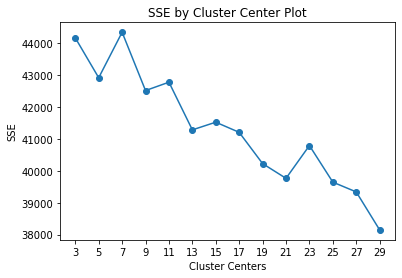

In [202]:
#Finding Optimal Clusters
def find_optimal_clusters(data, max_k):
    iters = range(3, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 30)

In [207]:
#k=21
df_tweet['clusters'] = KMeans(n_clusters=21, init='k-means++', max_iter=100, n_init=1).fit_predict(text)
clusters= KMeans(n_clusters=21, init='k-means++', max_iter=100, n_init=1).fit_predict(text) #added to visualize the hole numpy
print(df_tweet['clusters'])

0        15
1        15
3        15
4        15
5        15
         ..
62276    15
62277    15
62278    15
62279    15
62280    13
Name: clusters, Length: 48928, dtype: int32


In [208]:
np.set_printoptions(threshold=sys.maxsize)
print(clusters)

[ 1  1  1 20  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 20  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 18  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  4  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 19  1  1  1  1  1  1 19  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  9  1  1  1  1  1  1  1  1  1

48928


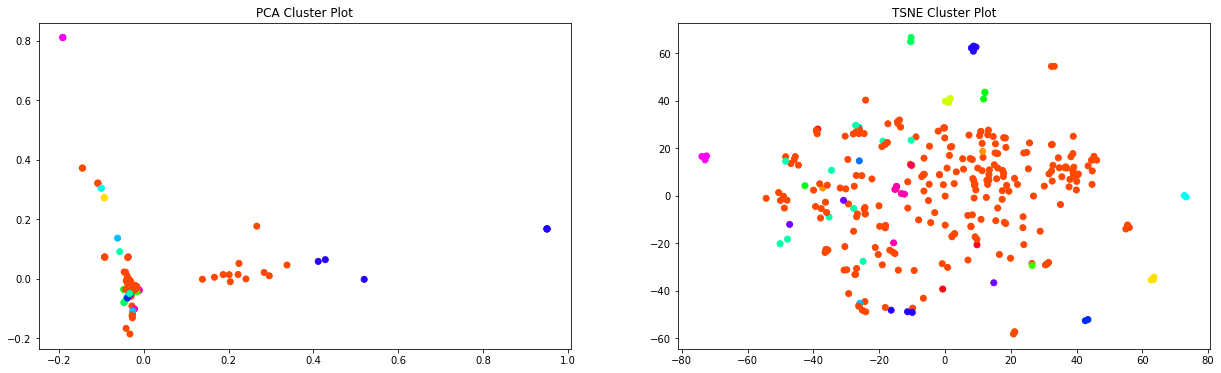

In [213]:
#Plotting Clusters
def plot_tsne(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(21, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)
print(len(clusters))

In [214]:
#Top Keywords
def get_top_keywords(data, clusters):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    df.head()
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(df_tweet[df_tweet['clusters']==i]['text'])
            
get_top_keywords(text, clusters)


Cluster 0
2993     RT @JonahDispatch: If you’re watching it, and ...
3393     RT @0613HoneyFM: hobi: 🥺 suga hyung I don’t kn...
3509     RT @SooChoiFolder: V: ARMYs, How are you? We r...
3566     RT @francisobrienUK: People sat at home watchi...
3700     RT @choi_bts2: @BTS_twt trans) MMA and MAMA, s...
                               ...                        
59898                    You are now watching PAWG'oVision
60104    RT @EXOsJules: THIS IS MY 10TH TIME WATCHING T...
61641    RT @Viriden23: 21 hours of stream later I'm fi...
61677    RT @NEAKO: The Virus Isn’t Just The Sickness O...
62010    RT @SEULMATES_: 🌟STARPLAY February Birthday Vo...
Name: text, Length: 183, dtype: object

Cluster 1
558                                   Oh shit!\n\nLove BHP
2996                  @BTS_twt we love you kim seokjin 💜💜💜
3012        @ATEEZofficial you  did  amazing  i  love  you
3078                 @VStreamTeam KIM TAEHYUNG WE LOVE YOU
3086                                    I FUCKING LOVE